In [2]:
%%R
library(reticulate)
use_condaenv('ethique_env')

UsageError: Cell magic `%%R` not found.


In [2]:
%%capture
%run ./german.ipynb

# Fairness 

# Les femmes sont discriminées

## Définition de la *fairness*

([source](https://en.wikipedia.org/wiki/Fairness_(machine_learning)))

On appel biais algorithmique une erreur systématique et reproductible d'un système informatique qui entraîne les sorties de ce système à favoriser un groupe d'individus plutôt qu'un autre. Cette notion est déjà abordé par Joseph Weizenbaum en 1967 qui décrivait les programmes informatique de l'époque mimiquant le raisonnement humain pour résoudre des problèmes. Il dit dans *Computer Power and Human Reason* que les règles que suivent les programmes internalisent la vision du monde de leur créateur ce qui inclue leur biais et leur attentes. Cela ne concerne également les algorithmes qui apprennent d'eux-même car toutes données fournies à l'algorithme reflètent la manière dont l'homme prends des décisions.

Le principe de *fairness* en apprentissage statistique corresponds aux différentes manières de corriger ou du moins de mitiger ce problème de biais algorithmique. Il est difficile voir impossible de donner une définition universelle de la *fairness* mais de manière générale on considère qu'un résultat est équitable s'il est indépendant d'un certain jeu de variables appelées *variables sensibles*. Pour une personnes les variables sensibles correspondent classiquement aux attributs comme le sexe, l'ethnicité, l'orientation sexuelle, ou tout autre caractéristiques sur lesquelles il est interdit de discriminé. 

Bien que le problème de biais algorithmique soit décrit depuis plus les années 70 les recherches en matière de *fairness* sont très récentes avec les publications les plus importantes datant seulement de 2018. (citer des papier ?) 

## Définition mathématique 

Bien que la définition de *fairness* paraisse intuitive, il est nécessaire de faire des hypothèse pour mettre en place une définition théorique. Il existe donc différentes définition de la *fairness* selon les hypothèses retenues. Néanmoins de manière générale l'objectif de ces définition est que la déviation (ou le biais statistique) d'une ou plusieurs *métriques de parité* doivent être minimisé pour tout les individus ou tout les groupes d'individus. 

Il existe un très grand nombre de ces métriques de parités ([liste](https://developers.google.com/machine-learning/glossary/fairness)). Il existe certain outils permettant d'orienté le choix vers une métrique plutôt qu'une autre en fonction du rôle qu'aura le modèle statistique. Par exemple [*Aquiteas*](https://github.com/dssg/aequitas), une trousse à outils de *fairness* développée par le centre *data science and public policy* de l'université de Chicago, propose l'arbre de décision suivant : 

![](http://www.datasciencepublicpolicy.org/wp-content/uploads/2021/04/Fairness-Full-Tree.png)


Nous allons nous attarder sur trois métriques en utilisant les notations suivantes :
 - $Y$ : la caractéristique binaire de sortie
 - $X$ : le vecteur de caractéristique d'entrées sans la caractéristique sensible
 - $S$ : la caractéristique sensible
 - $\hat{Y}$ : la prédiction de la caractéristique de sortie
 
 
**Définition 1 : *equalized odds***

On dit que $\hat{Y}$ satisfait l'égalité des chance par rapport à $S$ et $Y$ si :
$$
P(\hat{Y}=1 \mid S=0, Y=y)=P(\hat{Y}=1 \mid S=1, Y=y) ; \quad y=0,1
$$
Autrement dit, $\hat{Y}$ est indépendant de $S$ conditionnellement à $Y$.

**Définition 2 : *demographic parity***

On dit que $\hat{Y}$ satisfait la parité démographique par rapport à $S$ si :
$$
P(\hat{Y}=1 \mid S=0)=P(\hat{Y}=1 \mid S=1)
$$
Autrement dit, $\hat{Y}$ est indépendant de S.

**Définition 3 : *counterfactual fairness***

On dit que $\hat{Y}$ satisfait l'équité contrefactuelle par rapport à $S$ et $X$ si :
$$
P(\hat{Y}=1 \mid S=0, X=x)=P(\hat{Y}=1 \mid S=1, X=x)
$$
Autrement dit, $\hat{Y}$ est indépendant de $S$ conditionnellement à $X$.

L'égalité des chance et la parité démographique sont des métriques de parité de groupe (*group fairness*), on cherche à avoir le même traitement pour des groupes de personnes définie par leur variables sensibles $S$. Alors que l'équité contrefactuelle est une métrique de parité individuelle (*individual fairness*), on cherche à fournir un traitement similaire à des personnes similaires peut importe leur variables sensibles.
Il est tout à fait possible d'avoir une interaction entre deux métriques des deux groupes on a alors un *subgroup fairness*.

## Application de la *fairness*

Les problèmes de biais algorithmiques peuvent survenir des données ou du modèle c'est pour cela que l'on peut catégorisé les méthodes d'implémentation des solutions de *fairness* en trois parties :
 - pre-processing : ces méthodes qui ne dépendent pas du modèle tendent à mitiger les problèmes de *fairness* avant que les données soit utilisé dans un modèle statistique. Il s'agit souvent de transformer une ou plusieurs caractéristiques ou de changer la représentation des groupes.
 - in-processing : ces méthodes incorporent dans le processus d'entraînement les métriques que l'on cherche à minimiser.  
 - post-processing : ces méthodes n'ont pas besoin d'un accès au modèle d'entraînement mais au lieu de traiter le problème de *fairness* sur la base de données d'entraînement on se base sur les prédictions.  


Dans la suite nous allons illustrer les différents biais qu'il peut exister dans notre modèle de prédiction de défaut en prenant comme variable sensible le sexe de l'individu. Nous verrons ensuite l'implémentation de méthodes *pre-processing*, *post-processing* et *in-processing*.

## Mise en situation et implémentations

### Utilisation de la matrice de confusion

La majorité des mesures de partialité sont basées sur la matrice de confusion. Elle comporte quatre classes :
 - Vrai positif (VP) : la vraie classe est 1 et la classe prédite est 1
 - Faux positif (FP) : la vraie classe est 0 et la classe prédite est 1 
 - Vrai négatif (VN) : la vraie classe est 0 et la classe prédite est 0
 - Faux négatif (FN) : la vraie classe est 1 et la classe prédite est 0

Les métriques de partialité sont calculé à partir de ces 4 valeurs pour des groupes de personnes partagants des caractéristiques communes (sex, ethnicité) 

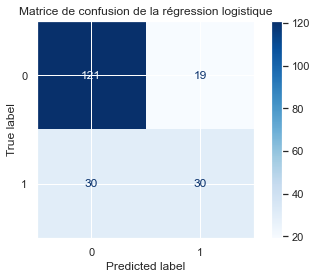

In [3]:
title = 'Matrice de confusion de la régression logistique'
disp = plot_confusion_matrix(logreg,
                             X_test,
                             y_test,
                             cmap=plt.cm.Blues)
ax = disp.ax_.set_title(title)
plt.show()

Dans cette représentation on a :
 - Vrai positif : bas à droite
 - Faux positif : haut à droite
 - Vrai négatif : haut à gauche
 - Faut négatif : bas à droite

## Métriques de parité

Pour illustrer la *fairness* on va utilisé notre modèle de régression logistique implémenté dans l'article *intro*. Pour calculer les différentes métriques nous utilisons la boîte à outils développé par IBM : *AI Fairness 360*. Cette boite à outils implémente les calculs des biais mais aussi les méthodes de mitigations de ceux-ci.

In [4]:
%%capture
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

La manière dont *AIF360* fonctionne pour le calcul de métrique de parité est la suivante :
 - On créer un dataframe (results) qui contient le $Y$, $\hat{Y}$ et la variable sensible en binaire

In [11]:
y_test = pd.Series(model.predict(X_test), index=X_test.index, name='test')
y_pred = pd.Series(y_test, index=X_test.index, name='pred')
sex_bin = X_test.sex.map({'male': 0, 'female': 1})

results = pd.concat([y_test, y_pred, sex_bin], axis=1)

results.head(3)

,test,pred,sex
297,0,0,0
333,0,0,1
920,0,0,1


 - On utilise l'objet BinaryLabelDataset en précisant le label et la variable sensible. Un pour les prédictions et un pour les tests. On fait également bien attention à préciser que le label 1 n'est pas positif pour la personne, il correspond à une prédiction de défaut.

In [12]:
bld_test = BinaryLabelDataset(df=results,
                              label_names=['test'], 
                              protected_attribute_names=['sex'],
                              favorable_label=0, 
                              unfavorable_label=1)

bld_pred = BinaryLabelDataset(df=results,
                              label_names=['pred'], 
                              protected_attribute_names=['sex'],
                              favorable_label=0, 
                              unfavorable_label=1)

 - On utilise ensuite l'objet *ClassificationMetric* qui prend en entrée deux *BinaryLabelDataset* et une classification des groupes privilégiés. Il permets ensuite de calculer un très grands nombre de métrique ([liste](https://aif360.readthedocs.io/en/latest/modules/sklearn.html#module-aif360.sklearn.metrics))

In [7]:
fairness_metrics = ClassificationMetric(bld_test, bld_pred, 
                                        unprivileged_groups=[{'sex': 1}],
                                        privileged_groups=[{'sex': 0}])

Average of difference in FPR and TPR for unprivileged and privileged
groups:

   $$\tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}})
   + (TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}))\right]$$

A value of 0 indicates equality of odds.

In [8]:
fairness_metrics.average_odds_difference()

-0.14944444444444446

$$Pr(\hat{Y} = 1 | D = \text{unprivileged})
   - Pr(\hat{Y} = 1 | D = \text{privileged})$$

In [9]:
fairness_metrics.statistical_parity_difference()

-0.19117647058823528

$$TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}$$

In [10]:
fairness_metrics.true_positive_rate_difference()

-0.16000000000000003

$$\frac{Pr(\hat{Y} = 1 | D = \text{unprivileged})}
   {Pr(\hat{Y} = 1 | D = \text{privileged})}$$

In [11]:
fairness_metrics.disparate_impact()

0.7657657657657658

In [12]:
fairness_metrics.accuracy()

0.755

# Comment mitiger les risques de discrimination

## Présentation des trois grandes familles 

### Pre-Processing

### In-Processing

### Post-Processing

## Implémentation des méthodes

### Pre-processing : *Reweight*

In [32]:
%%capture
from aif360.algorithms.preprocessing import Reweighing

In [33]:
rw = Reweighing(unprivileged_groups=[{'sex': 1}], 
                privileged_groups=[{'sex': 0}])

In [34]:
if 'sex' in cat_variables: cat_variables.remove('sex')

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_variables),
        ('ord', StandardScaler(), ord_variables)
    ])

X_train_proc = preprocess.fit_transform(X_train.drop(columns='sex'))
X_train_proc = pd.concat([pd.DataFrame(X_train_proc, index=X_train.index), 
                          X_train.sex.map({'male':0, 'female':1})], axis=1)

In [35]:
%%capture
bld_train = BinaryLabelDataset(df=pd.concat([X_train_proc, y_train], axis=1),
                                                label_names=['default'], 
                                                protected_attribute_names=['sex'],
                                                favorable_label=0, unfavorable_label=1)
bld_train = rw.fit_transform(bld_train)
w_train = bld_train.instance_weights.ravel()
model.fit(X_train, y_train, logreg__sample_weight = w_train)

In [36]:
y_test_pred = pd.Series(model.predict(X_test), index=X_test.index, name='defaut')
y_test = pd.Series(y_test, index=X_test.index, name='defaut')
sex_test = X_test.sex.map({'male': 0, 'female':1})

In [37]:
bld_test_pred = BinaryLabelDataset(df=pd.concat([y_test_pred, sex_test], axis=1),
                                                label_names=['defaut'], 
                                                protected_attribute_names=['sex'],
                                                favorable_label=0, unfavorable_label=1)
bld_test = BinaryLabelDataset(df=pd.concat([y_test, sex_test], axis=1),
                                           label_names=['defaut'], 
                                           protected_attribute_names=['sex'],
                                           favorable_label=0, unfavorable_label=1)

In [38]:
fairness_metrics = ClassificationMetric(bld_test, bld_test_pred, 
                         unprivileged_groups=[{'sex': 1}], privileged_groups=[{'sex': 0}])

In [39]:
fairness_metrics.average_odds_difference()

-0.09222222222222223

In [40]:
fairness_metrics.statistical_parity_difference()

-0.13786764705882348

In [41]:
fairness_metrics.true_positive_rate_difference()

-0.11499999999999999

In [42]:
fairness_metrics.disparate_impact()

0.826388888888889

In [43]:
fairness_metrics.accuracy()

0.75

### In-processing : ?

### Post-processing : *Calibrated Equal Odds*

In [25]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

In [26]:
cpp = CalibratedEqOddsPostprocessing(unprivileged_groups=[{'sex': 1}], 
                                   privileged_groups=[{'sex': 0}],
                                   cost_constraint='fpr')
cpp = cpp.fit(bld_test, bld_test_pred)

bld_test_pred = cpp.predict(bld_test_pred)

fairness_metrics = ClassificationMetric(bld_test, bld_test_pred, 
                         unprivileged_groups=[{'sex': 1}], privileged_groups=[{'sex': 0}])

In [27]:
fairness_metrics.average_odds_difference()

0.1547222222222222

In [28]:
fairness_metrics.statistical_parity_difference()

0.07444852941176472

In [29]:
fairness_metrics.true_positive_rate_difference()

-0.010000000000000009

In [30]:
fairness_metrics.disparate_impact()

1.0912162162162162

In [31]:
fairness_metrics.accuracy()

0.73

# Critique de la partie 2 et recommendations

## Compromis 
 - Est-ce que les hommes sont lésés par ces méthodes ?
 - Est-ce que ces méthodes sont beaucoup plus longues ?
 
## Ouverture 